In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt#to plot accuracy
import cv2
import tensorflow as tf
from PIL import Image, ImageEnhance
import os
from sklearn.model_selection import train_test_split #to split training and testing data
from pytorch_ood.detector import MaxSoftmax, ODIN, Mahalanobis, KNN
from pytorch_ood.utils import OODMetrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import ConcatDataset,DataLoader, Dataset
from torchvision import transforms
import os


c:\Users\15854\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from keras.utils import to_categorical#to convert the labels present in y_train and t_test into one-hot encoding
#from keras.models import Sequential, load_model
#from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout#to create CNN

In [8]:

detector = MaxSoftmax(model)
odin_detector = ODIN(model)
metrics = OODMetrics(model)



transform = transforms.Compose([
    transforms.ToTensor(),  # Scales to [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

In [17]:
data, labels = [],[]
OpenSetData, OpenSetLabels = [],[]
test_data,test_labels = [],[]
test_os_data, test_os_labels = [],[]
classes = 43
cutoffForOpenSet = 30
cur_path = os.getcwd()
#Retrieving the images and their labels
for i in range(classes):
   path = os.path.join(cur_path + '//' + "GTSRB",'train',str(i))
   images = os.listdir(path)
   for a in images:
        try:
           image = Image.open(path + '//'+ a)
           image = image.resize((30,30))
           image = np.array(image)
          #sim = Image.fromarray(image)
           if(i < cutoffForOpenSet):
            data.append(image)
            labels.append(i)
           else:
            OpenSetData.append(image)
            OpenSetLabels.append(i)
        except:
           print("Error loading image")

#now we get test set
path = os.path.join(cur_path + "//" + "GTSRB")
test_df = pd.read_csv(path + '//test.csv')

print(test_df.head(5))
image_path = test_df['Path']
label = test_df['ClassId']
for i in range(len(test_df)):   
   image = Image.open(path + '//' + image_path[i])
   image = image.resize((30,30))
   image = np.array(image)
   if(i < cutoffForOpenSet):
      test_data.append(image)
      test_labels.append(label[i])
   else:
      test_os_data.append(image)
      test_os_labels.append(image)



x = np.array(data)
y = np.array(labels)
x2 = np.array(OpenSetData)
y2 = np.array(OpenSetLabels)
xt = np.array(test_data)
yt = np.array(test_labels)
xt2 = np.array(test_os_data)
yt2 = np.array(test_os_labels)

print(x.shape, x2.shape, xt.shape, y.shape, y2.shape, yt.shape)
#Converting the labels into one hot encoding
y = to_categorical(y, 43)
y2 = to_categorical(y2, 43)
yt = to_categorical(yt, 43)
yt2 = to_categorical(yt2, 43)

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png
(31620, 30, 30, 3) (7589, 30, 30, 3) (30, 30, 30, 3) (31620,) (7589,) (30,)


MemoryError: Unable to allocate 10.9 GiB for an array with shape (34020000, 43) and data type float64

In [19]:


class TrafficSignsDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Change to (C, H, W)
        label = torch.tensor(label, dtype=torch.long)
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Create PyTorch datasets

train_dataset = TrafficSignsDataset(x, y) 
test_dataset = TrafficSignsDataset(xt, yt) 
fx = np.concatenate((xt,xt2))
fy = np.concatenate((yt,yt2))
full_test_dataset = TrafficSignsDataset(fx, fy)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 4 dimension(s)

In [11]:
import random
def augment_image(image):
    augmentations = []

    # 1. Horizontal Flip
    augmentations.append(image.transpose(Image.FLIP_LEFT_RIGHT))

    # 2. Rotation (-15 to 15 degrees)
    angle = random.randint(-15, 15)
    augmentations.append(image.rotate(angle))

    # 3. Color Jitter: Adjust Brightness, Contrast
    brightness = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    augmentations.append(brightness)
    contrast = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    augmentations.append(contrast)

    # 4. Add random noise
    img_array = np.array(image)
    noise = np.random.normal(0, 5, img_array.shape).astype(np.int16)  # Gaussian noise
    noisy_img = np.clip(img_array + noise, 0, 255).astype(np.uint8)
    augmentations.append(Image.fromarray(noisy_img))

    # 5. Random crop and resize
    crop_size = (25, 25)  # Crop to a smaller size
    image_cropped = image.crop((0, 0, crop_size[0], crop_size[1])).resize((30, 30))
    augmentations.append(image_cropped)

    return augmentations

In [14]:
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('GTSRB//Test.csv')

augmented_data = []
ood_data = []
ood_folder = 'GTSRB/OOD'

for ood_img in os.listdir(ood_folder):
    if ood_img.endswith(('.png', '.jpg', '.jpeg')):  
        ood_image_path = os.path.join(ood_folder, ood_img)
        ood_image = Image.open(ood_image_path).convert('RGB')
        ood_image = ood_image.resize((30, 30))


        ood_data.append(np.array(ood_image))

        augmented_images = augment_image(ood_image)
        for img in augmented_images:
            augmented_data.append(np.array(img))



for ood_img in os.listdir(ood_folder):
    if ood_img.endswith(('.png', '.jpg', '.jpeg')):  
        ood_image_path = os.path.join(ood_folder, ood_img)
        ood_image = Image.open(ood_image_path).convert('RGB')
        ood_image = ood_image.resize((30, 30)) 
        x = np.array(ood_image)
        ood_data.append(x)


ood_data = ood_data + augmented_data
print("OOD size", len(ood_data), "ID size" ,len(X_t2))

            
oodlab = len(ood_data) * [-1]

ood_dataset = TrafficSignsDataset(ood_data, oodlab) # transform= transform)
concatenated = ConcatDataset([test_dataset, ood_dataset])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
ood_loader = DataLoader(ood_dataset, batch_size=32, shuffle= False )
roc_data = []
binary_labels = []
scores, labels = [], []
for x, y in test_loader:
    #_, logits = detector(x)
    #metrics.update(logits, y)
    #score = logits.tolist()  # Get OOD scores
    #scores.extend(score)
    labels.extend(y.tolist())  # True labels    
    roc_data.append([scores, labels])  # Store for ROC computation
    binary_labels.extend((y == -1).int().tolist()) 
print(binary_labels)

print(f"Total number of images in data: {len(data)}")




OOD size 5120 ID size 7842
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [12]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [25]:
import seaborn as sns
#we want to plot frequency vs max softmax probs for both ood and id
#we use 10 bins
test_msps = []
ood_msps = []


#detector = Mahalanobis(model=model, eps=1e-6)
#detector.fit(train_features_tensor, labels)
detector = MaxSoftmax(model)

for x,y in test_loader:
    outputs = model(x)
    metrics.update(detector(x), y)
    softmax_out = F.softmax(outputs, dim = 1)
    max, _ = softmax_out.max(dim = 1)
    test_msps.extend(max.detach().numpy())
for x,y in ood_loader:
    outputs = model(x)
    metrics.update(detector(x), y)
    softmax_out = F.softmax(outputs, dim = 1)
    max, _ = softmax_out.max(dim = 1)
    ood_msps.extend(max.detach().numpy())

sns.kdeplot(test_msps, bw_adjust=0.5, fill=True, color='blue', label='ID')  # Blue for test data
sns.kdeplot(ood_msps, bw_adjust=0.5, fill=True, color='red', label='OOD')   # Red for OOD data


plt.title("KDE Plot of MSPs")
plt.xlabel("Max Softmax Probability (MSP)")
plt.ylabel("Density")
plt.legend(title="Data Type")  
plt.show()

print(metrics.compute())

ValueError: too many values to unpack (expected 2)

We note that using max softmax probabilities to distinguish between in distribution and out of distribution is a bad idea because some of the OOD data will have high MSP and will be falsely recognized as ID.

FPR95TPR: 25.5%

here, FPR95 measures fraction of OOD data misclassified as ID when threshold is chosen so that 95% of ID is above threshold.

{0}
area under curve nan
{'AUROC': 0.9530839323997498, 'AUPR-IN': 0.9966233968734741, 'AUPR-OUT': 0.5893701314926147, 'FPR95TPR': 0.1671767383813858}


c:\Users\15854\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


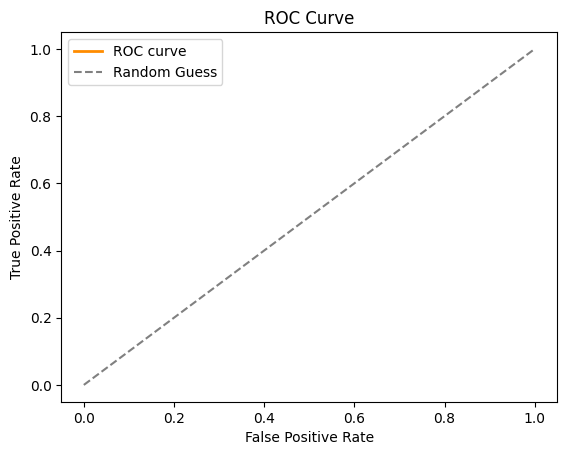

In [61]:
print(set(binary_labels))
fpr, tpr, thresholds = roc_curve(binary_labels,scores)
roc_auc = auc(fpr,tpr)
print('area under curve', roc_auc)
print(metrics.compute())


plt.figure()
plt.plot(fpr,tpr,color = 'darkorange', lw = 2, label = 'ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()

# Model

In [13]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)

        # Max pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 3 * 3, 256)  # Adjust input size after pooling
        self.fc2 = nn.Linear(256, 43)

        # Dropout layers
        self.dropout_conv = nn.Dropout(p=0.25)
        self.dropout_fc = nn.Dropout(p=0.5)

    def forward(self, x):
        # First Conv block
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout_conv(x)

        # Second Conv block
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout_conv(x)

        
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch

        # Fully connected layers
        features = F.relu(self.fc1(x))
        x = self.dropout_fc(features)
        logits = self.fc2(x)

        #return features, logits
        return logits

# Instantiate the model
model = TrafficSignNet()

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()



# Evaluation

In [14]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation
        for x, y in test_loader:
            outputs = model(x)
            loss = criterion(outputs, y)
            test_loss += loss.item() * x.size(0)  # Sum loss over the batch
            _, predicted = outputs.max(1)  # Get class with highest probability
            correct += (predicted == y).sum().item()
            total += y.size(0)
    
    avg_loss = test_loss / total  # Average loss over all test samples
    accuracy = correct / total  # Accuracy as a fraction
    return avg_loss, accuracy

In [64]:
model = TrafficSignNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"test loss {test_loss}, and accuracy {test_accuracy}")

test loss 3.993934016238667, and accuracy 0.0062484060188727365


In [65]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

# Train Loop

In [22]:
epochs = 10
batch_size = 32
train_features = []
train_features_tensor = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0 
    total_samples = 0 

    for inputs, labels in train_loader:  
      
        optimizer.zero_grad()
        outputs = model(inputs)
        #train_features.append(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        correct_predictions += (predicted == labels).sum().item()  # Count correct predictions
        total_samples += labels.size(0)  # Add batch size to total samples
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
    train_features_tensor = torch.cat(train_features, dim = 0)

    print(f"test loss {test_loss}, and accuracy {test_accuracy}")
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)}")
    epoch_accuracy = correct_predictions / total_samples
    print("Epoch Accuracy", epoch_accuracy)


# Save the model
torch.save(model.state_dict(), "my_model.pth")

test loss 0.10858763324262796, and accuracy 0.969905636317266
Epoch 1/10, Loss: 0.27007203715569533
Epoch Accuracy 0.922848853891032
test loss 0.08621663024964453, and accuracy 0.9769191532772252
Epoch 2/10, Loss: 0.2608461627531626
Epoch Accuracy 0.9272483820575764
test loss 0.08337273382448995, and accuracy 0.9818923743942872
Epoch 3/10, Loss: 0.2571626869521591
Epoch Accuracy 0.9301814008352728
test loss 0.07816033860795554, and accuracy 0.9806171894924764
Epoch 4/10, Loss: 0.22729311767778887
Epoch Accuracy 0.9368125737239774
test loss 0.0673171801272226, and accuracy 0.9820198928844682
Epoch 5/10, Loss: 0.21110882763594208
Epoch Accuracy 0.9429336563904741
test loss 0.10876620912478938, and accuracy 0.9728385615914308
Epoch 6/10, Loss: 0.22758734451990648
Epoch Accuracy 0.9383747250294896
test loss 0.06506103205424418, and accuracy 0.9829125223157358
Epoch 7/10, Loss: 0.22293817353944312
Epoch Accuracy 0.9399368763350018
test loss 0.0544603984497694, and accuracy 0.985845447589900

In [67]:
accuracy = 0
correct_predictions = 0 
total_samples = 0 
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:  
      
        optimizer.zero_grad()
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        correct_predictions += (predicted == labels).sum().item()  # Count correct predictions
        total_samples += labels.size(0)  # Add batch size to total samples

    accuracy = correct_predictions / total_samples
    print("accuracy", accuracy)
    

accuracy 0.9827850038255547


In [68]:

'''
#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_t1.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))
#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
eps = 15
anc = model.fit(X_t1, y_t1, batch_size=32, epochs=eps, validation_data=(X_t2, y_t2))
model.save("my_model.h5")
'''

'\n#Building the model\nmodel = Sequential()\nmodel.add(Conv2D(filters=32, kernel_size=(5,5), activation=\'relu\', input_shape=X_t1.shape[1:]))\nmodel.add(Conv2D(filters=32, kernel_size=(5,5), activation=\'relu\'))\nmodel.add(MaxPool2D(pool_size=(2, 2)))\nmodel.add(Dropout(rate=0.25))\nmodel.add(Conv2D(filters=64, kernel_size=(3, 3), activation=\'relu\'))\nmodel.add(Conv2D(filters=64, kernel_size=(3, 3), activation=\'relu\'))\nmodel.add(MaxPool2D(pool_size=(2, 2)))\nmodel.add(Dropout(rate=0.25))\nmodel.add(Flatten())\nmodel.add(Dense(256, activation=\'relu\'))\nmodel.add(Dropout(rate=0.5))\nmodel.add(Dense(43, activation=\'softmax\'))\n#Compilation of the model\nmodel.compile(loss=\'categorical_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\neps = 15\nanc = model.fit(X_t1, y_t1, batch_size=32, epochs=eps, validation_data=(X_t2, y_t2))\nmodel.save("my_model.h5")\n'

In [69]:
#plotting graphs for accuracy
plt.figure(0)
plt.plot(anc.history['accuracy'], label='training accuracy')
plt.plot(anc.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(anc.history['loss'], label='training loss')
plt.plot(anc.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


NameError: name 'anc' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
print(set(labels))
fpr, tpr, thresholds = roc_curve(labels,scores)
roc_auc = auc(fpr,tpr)
print('area under curve', roc_auc)
print(metrics.compute())


plt.figure()
plt.plot(fpr,tpr,color = 'darkorange', lw = 2, label = 'ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()

In [36]:
X_test=np.array(data)
#pred = model.predict_classes(X_test)
pred = np.argmax(model.predict(X_test),axis=-1)
print(len(pred), len(labels))
#Accuracy with the test data
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, pred))
model.save('traffic_classifier.h5')

AttributeError: 'TrafficSignNet' object has no attribute 'predict'